# 1. 序列模型

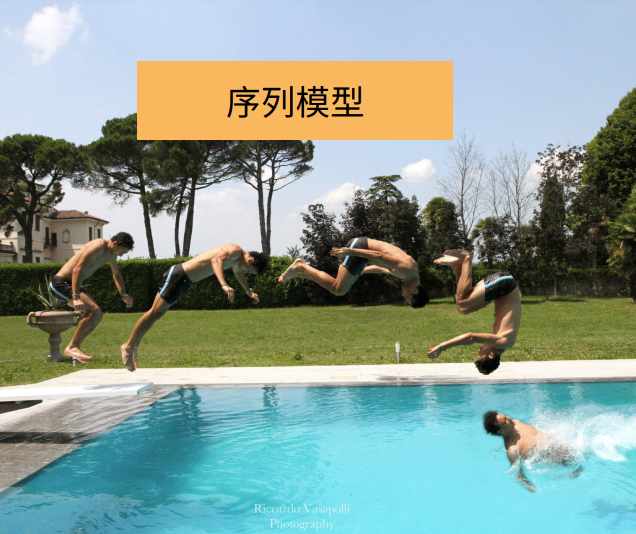

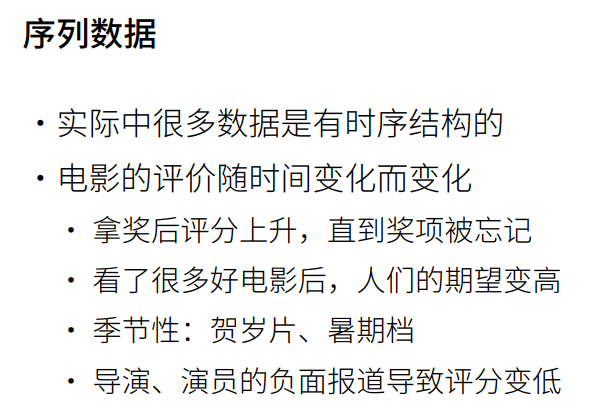

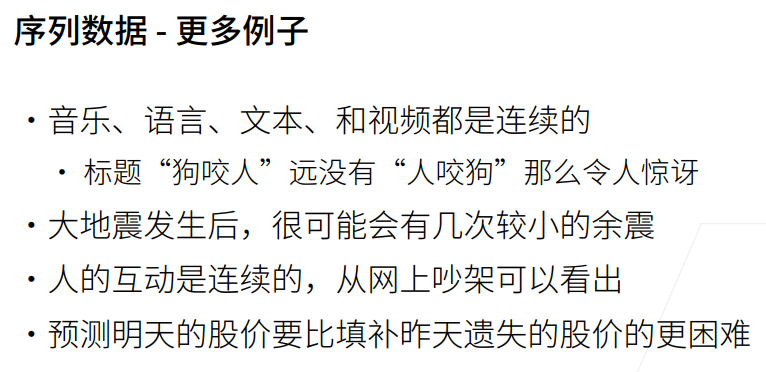

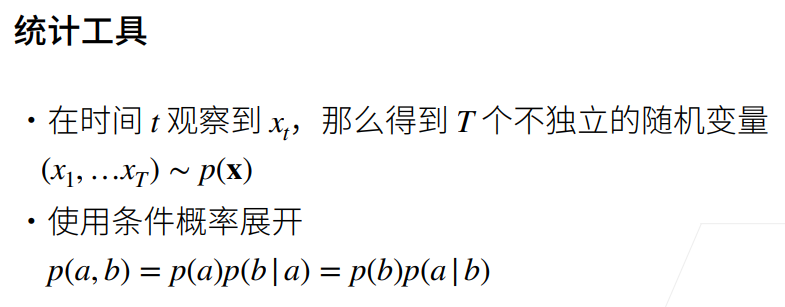

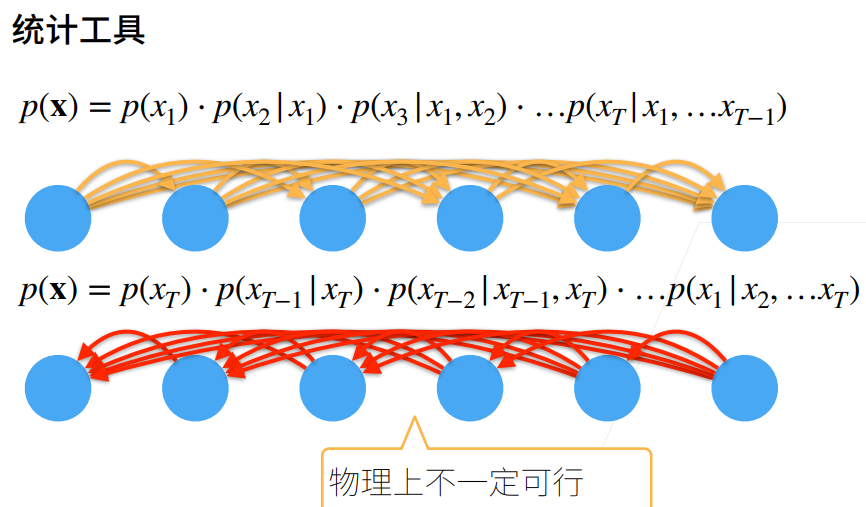

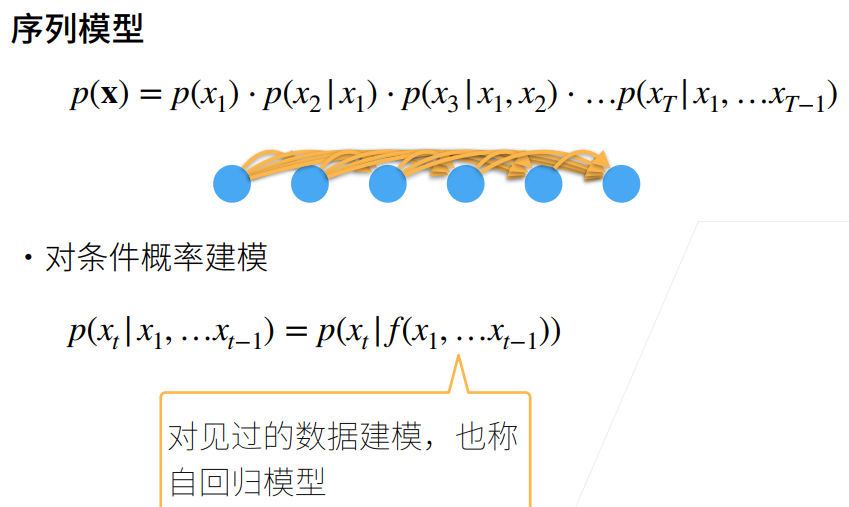

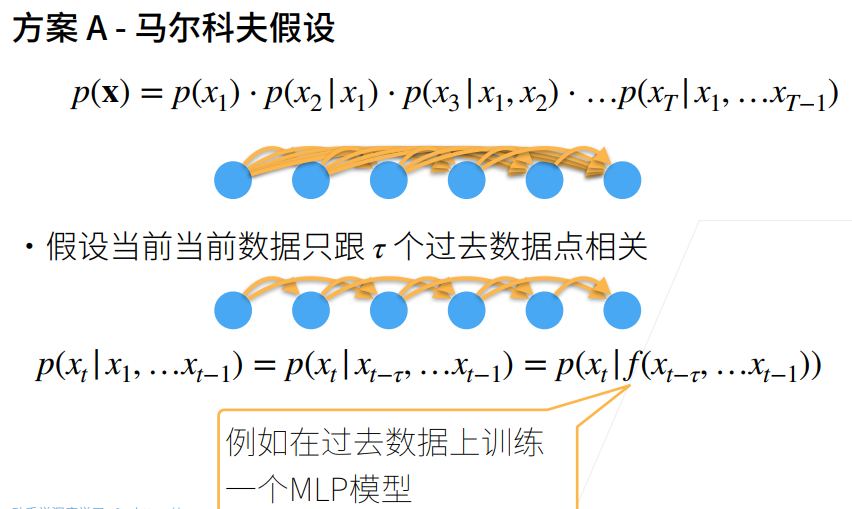

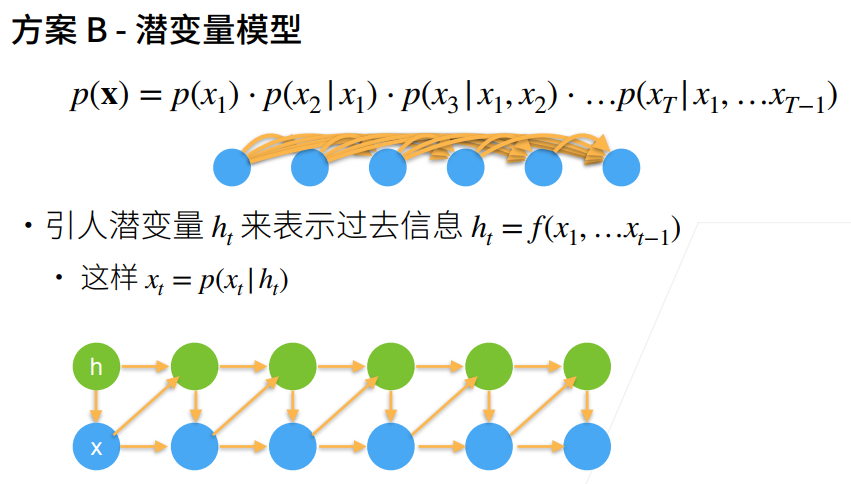

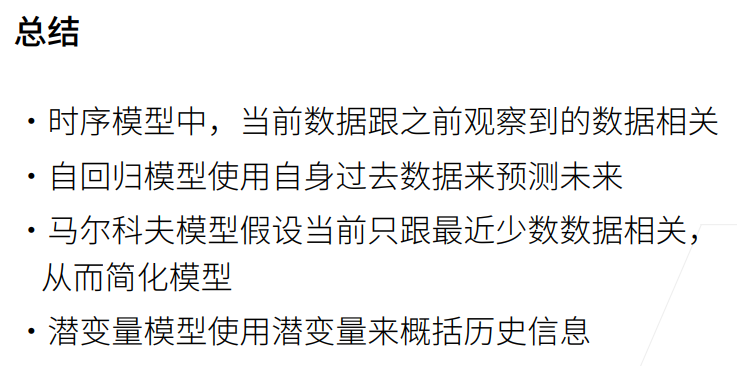

# 2. 序列模型

① 使用正弦函数和一些可加性噪声来生成序列数据，时间步为1,2,...,1000

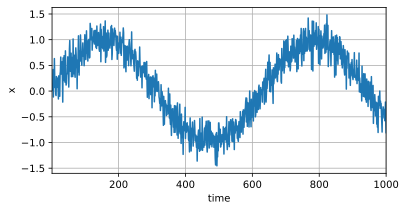

In [15]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype = torch.float32)  # 1到1000为时间
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))  # x是正弦函数+一个正态分布的噪音
d2l.plot(time, [x], 'time', 'x', xlim=[1,1000], figsize=(6,3))

② 将数据映射为数据对$y_t = x_t$和$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$

In [16]:
tau = 4
features = torch.zeros((T - tau, tau))  # T - tau 为样本数，tau 为特征数；也即共有996组数据，每组数据里是4个一组的向量

for i in range(tau):
    # 每四个数据作为特征，第五个作为标签，不断构造这样的数据形成数据集
    features[:, i] = x[i:T - tau + i]

# 所从第5个时刻开始，每个时刻的label是该时刻的x值，该时刻的输入是前4个时刻的数值组成的一个向量。
# 经过变化后数据的输入共有996组4个一组的数据，输出共996个值
labels = x[tau:].reshape((-1,1))

print(features.shape, labels.shape)  # 分别为 996*4 和 996*1

batch_size, n_train = 16, 600  # 取前600位训练集，batch_size为16
train_iter = d2l.load_array((features[:n_train],labels[:n_train]),
                           batch_size, is_train=True)

torch.Size([996, 4]) torch.Size([996, 1])


③ 使用一个相当简单的结构：只是一个拥有两个全连接层的多层感知机

In [17]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)  # 一个均匀分布的初始化？
    
def get_net():
    net = nn.Sequential(nn.Linear(4,10),nn.ReLU(),nn.Linear(10,1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss()

④ 训练模型

In [23]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
             f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
        
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.057984
epoch 2, loss: 0.052601
epoch 3, loss: 0.052206
epoch 4, loss: 0.051535
epoch 5, loss: 0.050368


⑤ 模型预测下一个时间步。

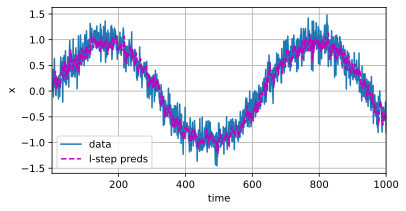

In [25]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
        [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
        legend = ['data','l-step preds'], xlim = [1, 1000], figsize=(6,3))   

⑥ 进行多步预测

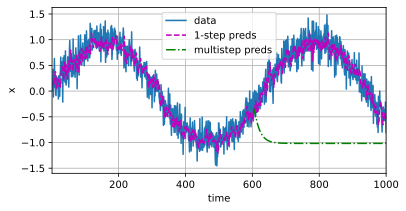

In [26]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
# 每次用新预测的出的值再去预测下一个点，不断迭代，将600-1000的点全部预测完成
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1,-1)))
    
# 多步预测会误差累加，导致错误的很离谱（绿线）
d2l.plot(
    [time, time[tau:], time[n_train + tau:]], 
    [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train + tau:].detach().numpy()],        
    'time', 
    'x', 
    legend = ['data', '1-step preds', 'multistep preds'], 
    xlim=[1,1000],
    figsize=(6,3) )  

⑦ 更仔细地看一下k步预测。

torch.Size([933, 68])


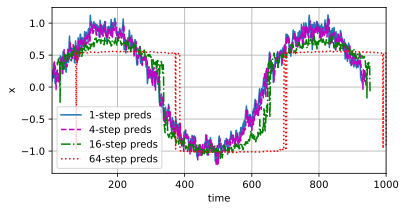

In [29]:
max_steps = 64 
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))  # (1000-4-64+1) * (4+64)
print(features.shape)
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]
    
# 分别为：前向预测步长steps从1到64的预测情况
for i in range(tau, tau + max_steps):
    features[:,i] = net(features[:, i - tau:i]).reshape(-1)
    
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
        [features[:, (tau + i - 1)].detach().numpy() for i in steps],
        'time',
        'x',
        legend = [f'{i}-step preds' for i in steps],
        xlim = [5,1000],
        figsize=(6,3) )